In [1]:
!pip install -r requirements.txt

Import the necessary modules. 

In [ ]:
import os
from os import listdir
from os.path import join
import shutil
import stat
import numpy as np
import cv2
from skimage.io import imread
import collections
from collections import defaultdict
import tensorflow.keras.backend
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
%matplotlib inline

Generating essential dictionaries and methods that will be make life simple.  

In [3]:
class_N, N_class = {}, {}
with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [i.strip() for i in txt.readlines()]
    class_N = dict(zip(classes, range(len(classes))))
    N_class = dict(zip(range(len(classes)), classes))
    class_N = {i: j for j, i in N_class.items()}
    
class_N_sorted = collections.OrderedDict(sorted(class_N.items()))
print(class_N)

{'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4, 'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9, 'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14, 'ceviche': 15, 'cheesecake': 16, 'cheese_plate': 17, 'chicken_curry': 18, 'chicken_quesadilla': 19, 'chicken_wings': 20, 'chocolate_cake': 21, 'chocolate_mousse': 22, 'churros': 23, 'clam_chowder': 24, 'club_sandwich': 25, 'crab_cakes': 26, 'creme_brulee': 27, 'croque_madame': 28, 'cup_cakes': 29, 'deviled_eggs': 30, 'donuts': 31, 'dumplings': 32, 'edamame': 33, 'eggs_benedict': 34, 'escargots': 35, 'falafel': 36, 'filet_mignon': 37, 'fish_and_chips': 38, 'foie_gras': 39, 'french_fries': 40, 'french_onion_soup': 41, 'french_toast': 42, 'fried_calamari': 43, 'fried_rice': 44, 'frozen_yogurt': 45, 'garlic_bread': 46, 'gnocchi': 47, 'greek_salad': 48, 'grilled_cheese_sandwich': 49, 'grilled_salmon': 50, 'guacamole': 5

In [4]:
def gen_dir_file_map(path):
    dir_files = defaultdict(list)
    with open(path, 'r') as txt:
        files = [i.strip() for i in txt.readlines()]
        for f in files:
            dir_name, id = f.split('/')
            dir_files[dir_name].append(id + '.jpg')
    return dir_files


def copytree(source, target, symlinks = False, ignore = None):
    if not os.path.exists(target):
        os.makedirs(target)
        shutil.copystat(source, target)
    data = os.listdir(source)
    
    if ignore:
        exclude = ignore(source, data)
        data = [x for x in data if x not in exclude]
        
    for item in data:
        src = os.path.join(source, item)
        dest = os.path.join(target, item)
        if symlinks and os.path.islink(src):
            if os.path.lexists(dest): 
                os.remove(dest)
            os.symlink(os.readlink(src), dest)
            try:
                st = os.lstat(src)
                mode = stat.S_IMODE(st.st_mode)
                os.lchmod(dest, mode)
            except: pass
        elif os.path.isdir(src): 
            copytree(src, dest, symlinks, ignore)
        else: 
            shutil.copy2(src, dest)

In [5]:
def load_images(path_to_imgs):
    resize_count = 0
    all_imgs, all_classes = [], []

    for _, subdir in enumerate(listdir(path_to_imgs)):
        imgs = listdir(join(path_to_imgs, subdir))
        classN = class_N[subdir]
        for img_name in imgs:
            img_arr = cv2.imread(join(path_to_imgs, subdir, img_name))
            img_arr_rs = img_arr
            img_arr_rs = cv2.resize(img_arr, (200,200),interpolation=cv2.INTER_AREA)
            resize_count += 1
            im_rgb = cv2.cvtColor(img_arr_rs, cv2.COLOR_BGR2RGB)
            all_imgs.append(im_rgb)
            all_classes.append(classN)

    return np.array(all_imgs), np.array(all_classes)

In [6]:
def ignore_train(d):
    subdir = d.split('/')[-1]
    train_dir_files = gen_dir_file_map('food-101/meta/train.txt')
    to_ignore = train_dir_files[subdir]
    return to_ignore


def ignore_test(d):
    subdir = d.split('/')[-1]
    test_dir_files = gen_dir_file_map('food-101/meta/test.txt')
    to_ignore = test_dir_files[subdir]
    return to_ignore


def gen_train_test_split(path_to_imgs = 'food-101/images' , target_path = 'food-101'):
    copytree(path_to_imgs, target_path + '/train', ignore=ignore_test)
    copytree(path_to_imgs, target_path + '/test', ignore=ignore_train)


def load_train_test_data(path_to_train_imgs, path_to_test_imgs):
    X_train, y_train = load_images(path_to_train_imgs)
    X_test, y_test = load_images(path_to_test_imgs)
    return X_train, y_train, X_test, y_test

In [7]:
if not os.path.isdir('./food-101/test') and not os.path.isdir('./food-101/train'):
    gen_train_test_split()  
    len_train = len(os.listdir('food-101/train'))
    len_test = len(os.listdir('food-101/test'))
    print(len_train, len_test)
else:
    print('train and test folders already exists.')
    len_train = len(os.listdir('food-101/train'))
    len_test = len(os.listdir('food-101/test'))
    print(len_train, len_test)

train and test folders already exists.
101 101


In [8]:
foods_sorted = sorted(os.listdir('food-101/images'))
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

(384, 512, 3)


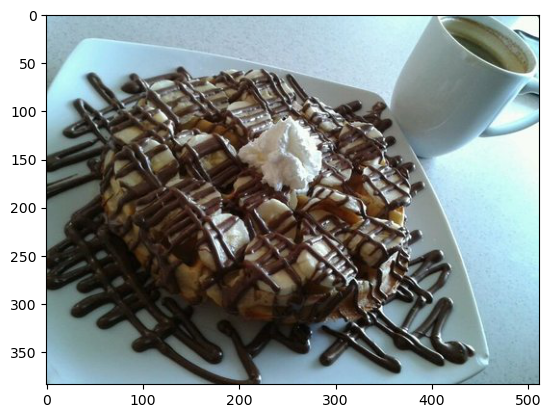

In [9]:
testImg = imread('food-101/test/waffles/1236559.jpg')
print(testImg.shape)
plt.imshow(testImg)

In [ ]:
X_train, y_train, X_test, y_test = load_train_test_data('food-101/train','food-101/test')

Fitting the data on the Inception-v3 model.

In [ ]:
tensorflow.keras.backend.clear_session()

n_classes = 101
batch_size = 16
width, height = 200, 200
train_data = 'food-101/train'
test_data = 'food-101/test'
train_samples = 75750
test_samples = 25250

train_data_gen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_data_gen  = ImageDataGenerator(rescale=1. / 255)

train_gen = train_data_gen.flow_from_directory(train_data, target_size=(height, width), batch_size=batch_size, class_mode='categorical')
test_gen  = test_data_gen.flow_from_directory(test_data, target_size=(height, width),   batch_size=batch_size, class_mode='categorical')

In [ ]:
inception = InceptionV3(weights='imagenet', include_top=False)
layer = inception.output
layer = GlobalAveragePooling2D()(layer)
layer = Dense(128,activation='relu')(layer)
layer = Dropout(0.2)(layer)

predictions = Dense(n_classes,kernel_regularizer=regularizers  .l2(0.005), activation='softmax')(layer)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_101class.keras', save_best_only=True)
csv_logger = CSVLogger('history_101class.log')

history_101class = model.fit(train_gen, steps_per_epoch= train_samples // batch_size, validation_data= test_gen, validation_steps= test_samples // batch_size, epochs=30, callbacks=[csv_logger, checkpointer])

model.save('model_trained_101class.keras')

In [ ]:
class_map_101 = train_gen.class_indices
class_map_101

In [ ]:
_ = plt.style.library['seaborn-darkgrid']
_ = plt.title('FOOD_CLASSIFICATION-Inceptionv3')
_ = plt.plot(history_101class.history['accuracy'], marker='o', linestyle='dashed')
_ = plt.plot(history_101class.history['val_accuracy'], marker='x', linestyle='dashed')
_ = plt.ylabel('Accuracy')
_ = plt.xlabel('Epoch')
_ = plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
plt.show()

In [ ]:
_ = plt.style.library['seaborn-darkgrid']
_ = plt.title('FOOD_CLASSIFICATION-Inceptionv3')
_ = plt.plot(history_101class.history['loss'], marker='o', linestyle='dashed')
_ = plt.plot(history_101class.history['val_loss'], marker='x', linestyle='dashed')
_ = plt.ylabel('Loss')
_ = plt.xlabel('Epoch')
_ = plt.legend(['train_loss', 'validation_loss'], loc='best')
plt.show()

In [ ]:
tensorflow.keras.backend.clear_session()
model_best = load_model('best_model_101class.keras',compile = False)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0curl: (6) Could not resolve host: cdn.sallysbakingaddiction.com
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 46 68048   46 31861    0     0  28811      0  0:00:02  0:00:01  0:00:01 28859
100 68048  100 68048    0     0  49722      0  0:00:01  0:00:01 --:--:-- 49815
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 15 63110   15  9646    0     0  22367      0  0:00:02 --:--:--  

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


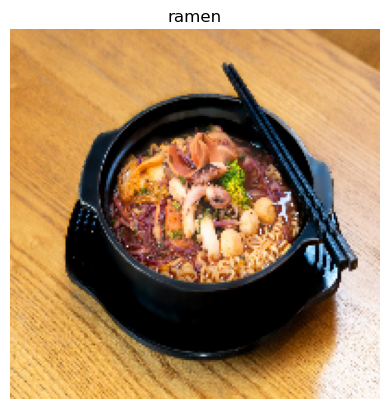

In [ ]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(200, 200))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img = img / 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    foods_sorted.sort()
    pred_value = foods_sorted[index]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

images = ['test_images/micay.jpg']
predict_class(model_best, images, True)